In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [39]:
def report_performance(actual,pred,predict_proba=None):
    print(f"Accuracy: {accuracy_score(actual,pred):.4f}, F1: {f1_score(actual,pred):.4f}")
    print(f"Precision: {precision_score(actual,pred):.4f}, Recall: {recall_score(actual,pred):.4f}")
    if predict_proba is not None:
        print(f"ROC AUC: {roc_auc_score(actual,predict_proba):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(actual,pred)}")

In [3]:
df = pd.read_csv('parsed_games.csv')

In [4]:
df['rating_diff'] = df['white_elo'] - df['black_elo']

In [5]:
df = pd.get_dummies(df.dropna(), columns=['white_castles','black_castles','time_control'])

In [6]:
df['baseline_prediction'] = (df['white_elo'] >= df['black_elo']).astype(int)

In [7]:
report_performance(df['white_win'],df['baseline_prediction'])

Accuracy: 0.6486, F1: 0.6483
Precision: 0.6502, Recall: 0.6464
Confusion Matrix:
[[1238713  664638]
 [ 675549 1235145]]


In [8]:
df.columns

Index(['total_moves', 'white_win', 'white_elo', 'black_elo', 'eco',
       'white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'bl

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.dropna().drop('white_win',axis=1),
    df.dropna()['white_win'],
    test_size = 0.2,
    random_state = 1
)

In [10]:
drop1 = ['total_moves', 'white_elo', 'black_elo', 'eco', 'baseline_prediction']
X_train1 = X_train.drop(drop1,axis=1).astype(np.int64)
X_test1 = X_test.drop(drop1,axis=1).astype(np.int64)

In [11]:
X_train1.columns

Index(['white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'black_total_rooks',
       'black_total_queens', 'white_total_attacked

In [15]:
drop2 = ['total_moves', 'white_elo', 'black_elo', 'rating_diff', 'eco', 'baseline_prediction', 'time_control_blitz', 'time_control_bullet', 'time_control_classical', 'time_control_rapid']
X_train2 = X_train.drop(drop2,axis=1).astype(np.int64)
X_test2 = X_test.drop(drop2,axis=1).astype(np.int64)

In [16]:
X_train2.columns

Index(['white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'black_total_rooks',
       'black_total_queens', 'white_total_attacked

In [19]:
X_train1_train, X_train1_val, y_train_train, y_train_val = train_test_split(
    X_train1,
    y_train,
    test_size = 0.25,
    random_state = 1
)

xgb_model1 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=15)
xgb_model1.fit(X_train1_train,y_train_train,
              eval_set=[(X_train1_train,y_train_train),(X_train1_val,y_train_val)],
              verbose=True
             )

[0]	validation_0-logloss:0.65331	validation_1-logloss:0.65321
[1]	validation_0-logloss:0.63142	validation_1-logloss:0.63133
[2]	validation_0-logloss:0.61872	validation_1-logloss:0.61860
[3]	validation_0-logloss:0.61016	validation_1-logloss:0.61007
[4]	validation_0-logloss:0.60487	validation_1-logloss:0.60479
[5]	validation_0-logloss:0.60150	validation_1-logloss:0.60147
[6]	validation_0-logloss:0.59884	validation_1-logloss:0.59889
[7]	validation_0-logloss:0.59639	validation_1-logloss:0.59647
[8]	validation_0-logloss:0.59440	validation_1-logloss:0.59453
[9]	validation_0-logloss:0.59296	validation_1-logloss:0.59314
[10]	validation_0-logloss:0.59123	validation_1-logloss:0.59144
[11]	validation_0-logloss:0.58966	validation_1-logloss:0.58987
[12]	validation_0-logloss:0.58844	validation_1-logloss:0.58871
[13]	validation_0-logloss:0.58706	validation_1-logloss:0.58735
[14]	validation_0-logloss:0.58593	validation_1-logloss:0.58625
[15]	validation_0-logloss:0.58507	validation_1-logloss:0.58541
[1

[130]	validation_0-logloss:0.56861	validation_1-logloss:0.57444
[131]	validation_0-logloss:0.56856	validation_1-logloss:0.57445
[132]	validation_0-logloss:0.56851	validation_1-logloss:0.57443
[133]	validation_0-logloss:0.56845	validation_1-logloss:0.57443
[134]	validation_0-logloss:0.56839	validation_1-logloss:0.57442
[135]	validation_0-logloss:0.56834	validation_1-logloss:0.57441
[136]	validation_0-logloss:0.56828	validation_1-logloss:0.57441
[137]	validation_0-logloss:0.56824	validation_1-logloss:0.57441
[138]	validation_0-logloss:0.56819	validation_1-logloss:0.57442
[139]	validation_0-logloss:0.56814	validation_1-logloss:0.57441
[140]	validation_0-logloss:0.56809	validation_1-logloss:0.57441
[141]	validation_0-logloss:0.56805	validation_1-logloss:0.57441
[142]	validation_0-logloss:0.56799	validation_1-logloss:0.57440
[143]	validation_0-logloss:0.56796	validation_1-logloss:0.57440
[144]	validation_0-logloss:0.56791	validation_1-logloss:0.57439
[145]	validation_0-logloss:0.56786	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
xgb_pred1 = pd.Series(xgb_model1.predict(X_test1))
report_performance(y_test,xgb_pred1,pd.Series(xgb_model1.predict_proba(X_test1)[:,1]))

Accuracy: 0.6904, F1: 0.6914
Precision: 0.6912, Recall: 0.6916
ROC AUC: 0.7644
Confusion Matrix:
[[327540 147761]
 [147458 330753]]


In [52]:
xgb_model1.best_iteration

160

In [37]:
X_train2_train, X_train2_val, y_train_train, y_train_val = train_test_split(
    X_train2,
    y_train,
    test_size = 0.25,
    random_state = 1
)

xgb_model2 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=15)
xgb_model2.fit(X_train2_train,y_train_train,
              eval_set=[(X_train2_train,y_train_train),(X_train2_val,y_train_val)],
              verbose=True
             )

[0]	validation_0-logloss:0.67918	validation_1-logloss:0.67912
[1]	validation_0-logloss:0.67088	validation_1-logloss:0.67087
[2]	validation_0-logloss:0.66550	validation_1-logloss:0.66547
[3]	validation_0-logloss:0.66127	validation_1-logloss:0.66126
[4]	validation_0-logloss:0.65703	validation_1-logloss:0.65711
[5]	validation_0-logloss:0.65396	validation_1-logloss:0.65401
[6]	validation_0-logloss:0.65224	validation_1-logloss:0.65227
[7]	validation_0-logloss:0.65002	validation_1-logloss:0.65007
[8]	validation_0-logloss:0.64824	validation_1-logloss:0.64829
[9]	validation_0-logloss:0.64676	validation_1-logloss:0.64684
[10]	validation_0-logloss:0.64514	validation_1-logloss:0.64527
[11]	validation_0-logloss:0.64382	validation_1-logloss:0.64396
[12]	validation_0-logloss:0.64284	validation_1-logloss:0.64302
[13]	validation_0-logloss:0.64189	validation_1-logloss:0.64208
[14]	validation_0-logloss:0.64106	validation_1-logloss:0.64128
[15]	validation_0-logloss:0.64026	validation_1-logloss:0.64054
[1

[130]	validation_0-logloss:0.62421	validation_1-logloss:0.63012
[131]	validation_0-logloss:0.62416	validation_1-logloss:0.63012
[132]	validation_0-logloss:0.62412	validation_1-logloss:0.63012
[133]	validation_0-logloss:0.62406	validation_1-logloss:0.63013
[134]	validation_0-logloss:0.62402	validation_1-logloss:0.63012
[135]	validation_0-logloss:0.62396	validation_1-logloss:0.63011
[136]	validation_0-logloss:0.62391	validation_1-logloss:0.63010
[137]	validation_0-logloss:0.62387	validation_1-logloss:0.63011
[138]	validation_0-logloss:0.62382	validation_1-logloss:0.63012
[139]	validation_0-logloss:0.62376	validation_1-logloss:0.63010
[140]	validation_0-logloss:0.62373	validation_1-logloss:0.63010
[141]	validation_0-logloss:0.62369	validation_1-logloss:0.63010
[142]	validation_0-logloss:0.62363	validation_1-logloss:0.63008
[143]	validation_0-logloss:0.62358	validation_1-logloss:0.63008
[144]	validation_0-logloss:0.62353	validation_1-logloss:0.63007
[145]	validation_0-logloss:0.62349	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
xgb_pred2 = pd.Series(xgb_model2.predict(X_test2))
report_performance(y_test,xgb_pred2,pd.Series(xgb_model2.predict_proba(X_test2)[:,1]))

Accuracy: 0.6365, F1: 0.6372
Precision: 0.6380, Recall: 0.6363
ROC AUC: 0.6949
Confusion Matrix:
[[302614 172687]
 [173907 304304]]


In [51]:
xgb_model2.best_iteration

174

In [47]:
lr_model1 = LogisticRegression(max_iter=1000,penalty='elasticnet',solver='saga',l1_ratio=0.1).fit(X_train1,y_train)

In [48]:
for i,feature in enumerate(lr_model1.feature_names_in_):
    print(f'\t{feature}: {lr_model1.coef_[0,i]}')
lr_model1_pred = lr_model1.predict(X_test1)
report_performance(y_test,lr_model1_pred,lr_model1.predict_proba(X_test1)[:,1])

	white_total_left_wing_pawn_moves: 0.012807981360263902
	white_total_center_pawn_moves: 0.0017076282213647153
	white_total_right_wing_pawn_moves: 0.026880827957387807
	white_total_knight_moves: 0.002352623735474016
	white_total_bishop_moves: 0.0015922664292567362
	white_total_rook_moves: 0.003143272650354867
	white_total_queen_moves: -0.010340748029198422
	white_total_king_moves: -0.030958968290792473
	black_total_left_wing_pawn_moves: -0.010458893686402944
	black_total_center_pawn_moves: -0.0010391655367311078
	black_total_right_wing_pawn_moves: -0.015306353881798539
	black_total_knight_moves: -0.008606870741234238
	black_total_bishop_moves: -0.011640385545430466
	black_total_rook_moves: -0.009474901265104235
	black_total_queen_moves: 0.008634648784451596
	black_total_king_moves: 0.021796757928291634
	white_doubled_pawn_files: 0.03398306270034041
	black_doubled_pawn_files: -0.0288096872157562
	white_no_pawn_files: -0.06840466958556225
	black_no_pawn_files: 0.06495511280248772
	white_t

In [53]:
lr_model2 = LogisticRegression(max_iter=1000,penalty='elasticnet',solver='saga',l1_ratio=0.1).fit(X_train2,y_train)

In [56]:
for i,feature in enumerate(lr_model2.feature_names_in_):
    print(f'\t{feature}: {lr_model2.coef_[0,i]}')
lr_model2_pred = lr_model2.predict(X_test2)
report_performance(y_test,lr_model2_pred,lr_model2.predict_proba(X_test2)[:,1])

	white_total_left_wing_pawn_moves: 0.0708446362931203
	white_total_center_pawn_moves: 0.05981448704930995
	white_total_right_wing_pawn_moves: 0.07787404956391014
	white_total_knight_moves: 0.05582123116391498
	white_total_bishop_moves: 0.05948550441504974
	white_total_rook_moves: 0.06315673951819242
	white_total_queen_moves: 0.03817807216641588
	white_total_king_moves: 0.030243563671856138
	black_total_left_wing_pawn_moves: -0.08455553830530292
	black_total_center_pawn_moves: -0.06650389238357106
	black_total_right_wing_pawn_moves: -0.07544989439059695
	black_total_knight_moves: -0.07306083712800444
	black_total_bishop_moves: -0.08156574554564829
	black_total_rook_moves: -0.08142165948840299
	black_total_queen_moves: -0.05194754213278477
	black_total_king_moves: -0.04392924878836617
	white_doubled_pawn_files: 0.005846849687900755
	black_doubled_pawn_files: -0.028301328843937733
	white_no_pawn_files: -0.05531882712107192
	black_no_pawn_files: 0.08100674088661204
	white_total_isolated_pa

In [86]:
y_test.drop()

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

In [143]:
X_test['material_difference'] = X_test['white_total_pawns'] + 3*X_test['white_total_knights'] + 3*X_test['white_total_bishops'] + 5*X_test['white_total_rooks'] + 9*X_test['white_total_queens'] - (X_test['black_total_pawns'] + 3*X_test['black_total_knights'] + 3*X_test['black_total_bishops'] + 5*X_test['black_total_rooks'] + 9*X_test['black_total_queens'])
X_test['material_difference_abs'] = X_test['material_difference'].abs()
X_test['material_difference_abs_buckets'] = pd.cut(X_test['material_difference'].abs(),[1,4,7,10,15,20,25,30,50])
X_test['rating_diff_buckets'] = pd.cut(X_test['rating_diff'].abs(),[0,25,50,75,100,125,150,175,200,250,300,350,400,5000])
X_test['total_move_buckets'] = pd.cut(X_test['total_moves'],[50,60,70,80,90,100,110,500],right=False)
X_test['white_win'] = y_test

X_test['correct_baseline'] = (X_test['white_elo'] >= X_test['black_elo']).astype(int)
X_test['correct_xgb1'] = (xgb_pred1.values == y_test.values).astype(int)
X_test['correct_xgb2'] = (xgb_pred2.values == y_test.values).astype(int)
X_test['correct_lr1'] = (lr_model1_pred == y_test.values).astype(int)
X_test['correct_lr2'] = (lr_model2_pred == y_test.values).astype(int)

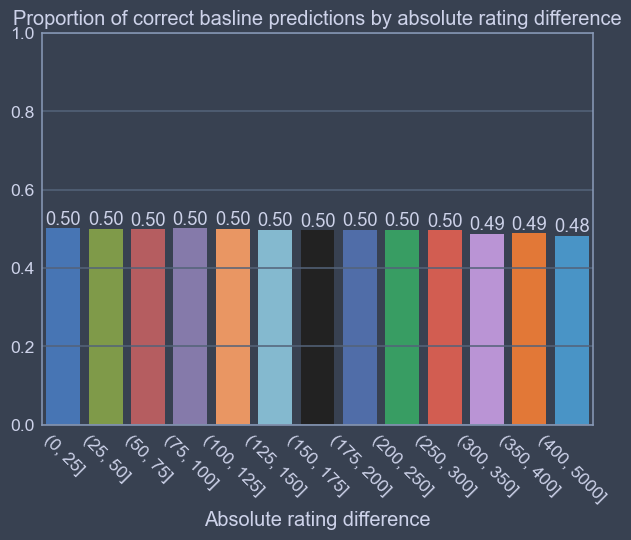

In [142]:
tempdf = X_test[['rating_diff_buckets','correct_baseline']].groupby(by='rating_diff_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_baseline'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct basline predictions by absolute rating difference')
plt.ylabel('')
plt.xlabel('Absolute rating difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/baselineaccuracybyratingdifference.png')

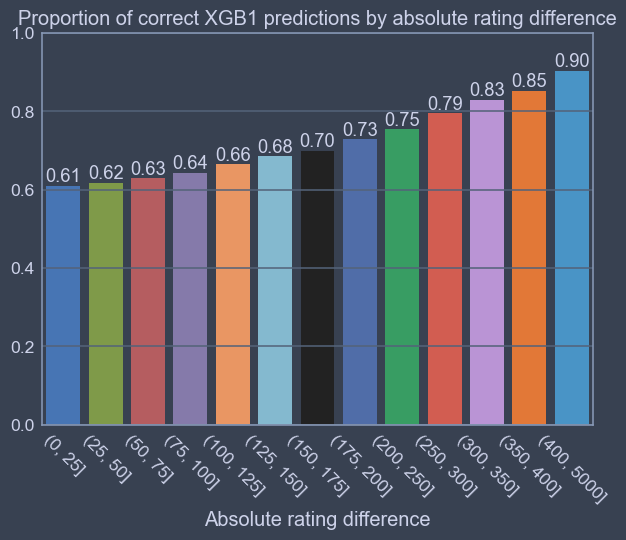

In [109]:
tempdf = X_test[['rating_diff_buckets','correct_xgb1']].groupby(by='rating_diff_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb1'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB1 predictions by absolute rating difference')
plt.ylabel('')
plt.xlabel('Absolute rating difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb1accuracybyratingdifference.png')

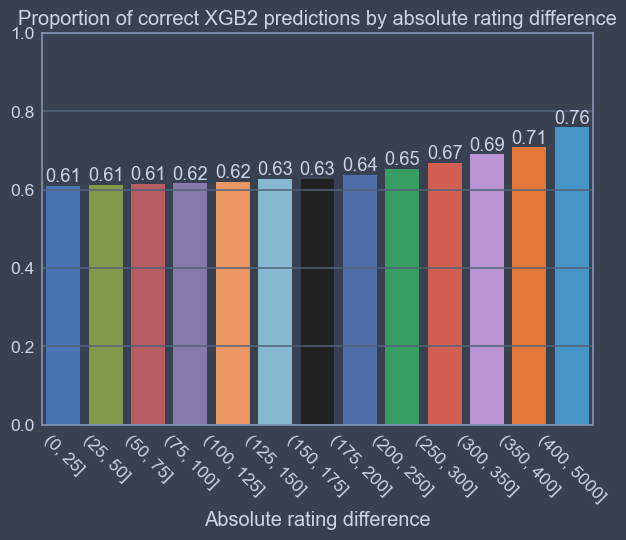

In [110]:
tempdf = X_test[['rating_diff_buckets','correct_xgb2']].groupby(by='rating_diff_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb2'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB2 predictions by absolute rating difference')
plt.ylabel('')
plt.xlabel('Absolute rating difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb2accuracybyratingdifference.png')

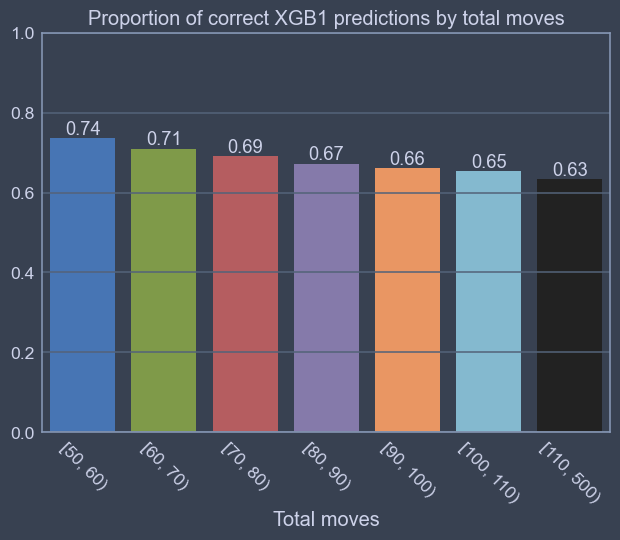

In [140]:
tempdf = X_test[['total_move_buckets','correct_xgb1']].groupby(by='total_move_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb1'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB1 predictions by total moves')
plt.ylabel('')
plt.xlabel('Total moves')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb1accuracybymoves.png')

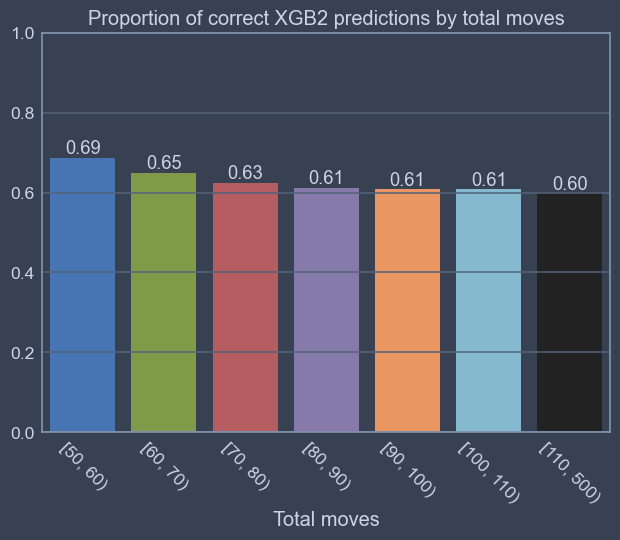

In [116]:
tempdf = X_test[['total_move_buckets','correct_xgb2']].groupby(by='total_move_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb2'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB2 predictions by total moves')
plt.ylabel('')
plt.xlabel('Total moves')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb2accuracybymoves.png')

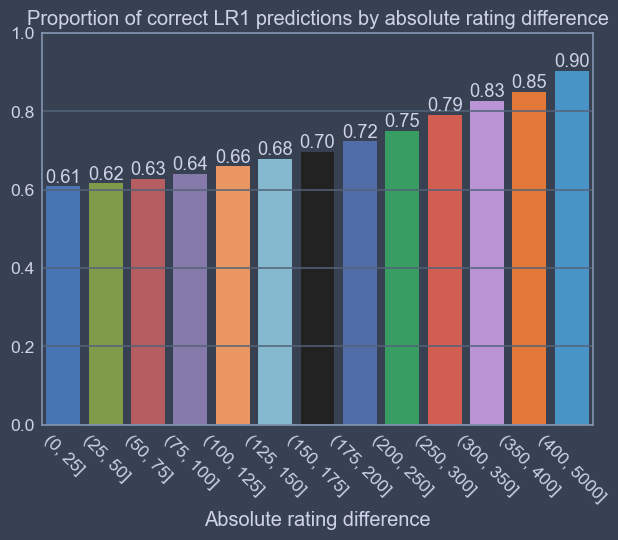

In [113]:
tempdf = X_test[['rating_diff_buckets','correct_lr1']].groupby(by='rating_diff_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr1'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct LR1 predictions by absolute rating difference')
plt.ylabel('')
plt.xlabel('Absolute rating difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr1accuracybyratingdifference.png')

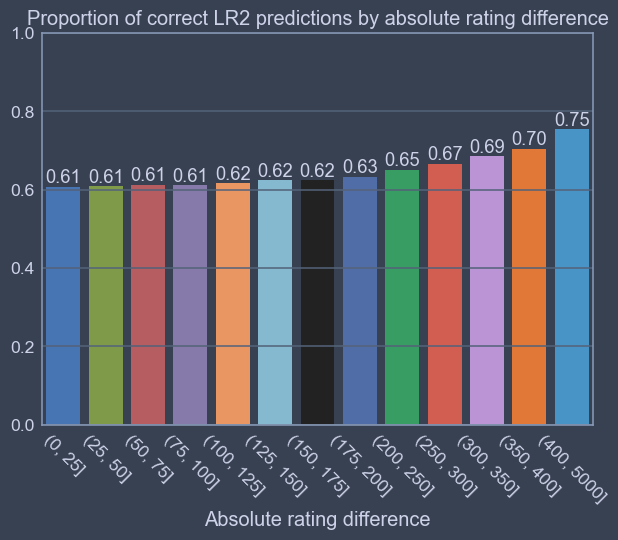

In [114]:
tempdf = X_test[['rating_diff_buckets','correct_lr2']].groupby(by='rating_diff_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr2'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct LR2 predictions by absolute rating difference')
plt.ylabel('')
plt.xlabel('Absolute rating difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr2accuracybyratingdifference.png')

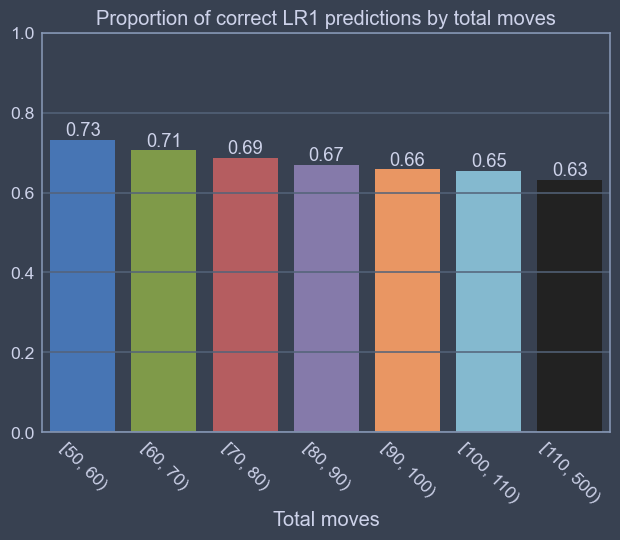

In [115]:
tempdf = X_test[['total_move_buckets','correct_lr1']].groupby(by='total_move_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr1'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct LR1 predictions by total moves')
plt.ylabel('')
plt.xlabel('Total moves')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr1accuracybymoves.png')

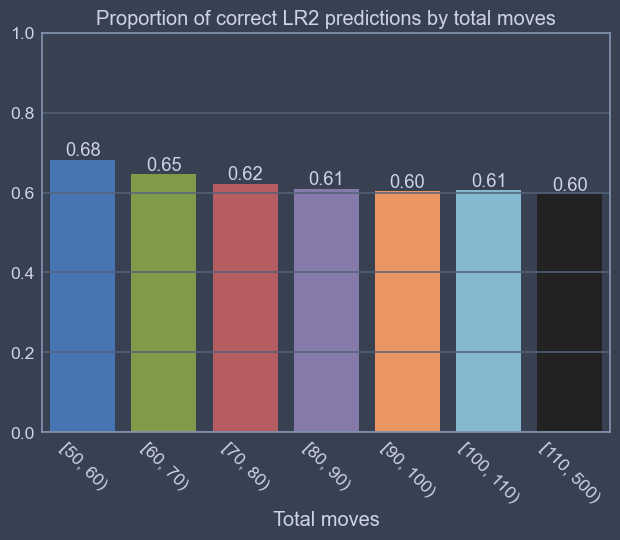

In [118]:
tempdf = X_test[['total_move_buckets','correct_lr2']].groupby(by='total_move_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr2'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct LR2 predictions by total moves')
plt.ylabel('')
plt.xlabel('Total moves')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr2accuracybymoves.png')

In [139]:
X_test[['material_difference_abs']].groupby(by='material_difference_abs').size()

material_difference_abs
0     275878
1     235667
2     128641
3     101541
4      58976
5      43397
6      30432
7      20462
8      15522
9      13519
10      8712
11      5782
12      4203
13      3059
14      2102
15      1500
16      1071
17       777
18       598
19       480
20       290
21       232
22       171
23       136
24        84
25        71
26        51
27        39
28        31
29        26
30         9
31         9
32        11
33         9
34         9
35         5
36         4
37         2
41         1
44         1
45         1
47         1
dtype: int64

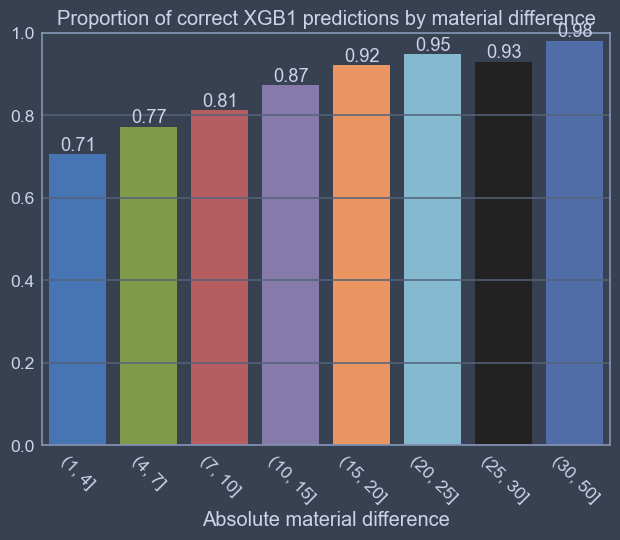

In [151]:
tempdf = X_test[['material_difference_abs_buckets','correct_xgb1']].groupby(by='material_difference_abs_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb1'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB1 predictions by material difference')
plt.ylabel('')
plt.xlabel('Absolute material difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb1accuracybymaterialdifference.png')

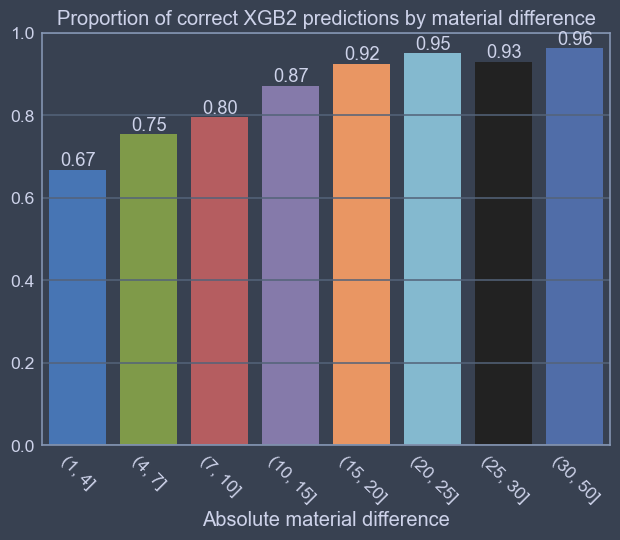

In [150]:
tempdf = X_test[['material_difference_abs_buckets','correct_xgb2']].groupby(by='material_difference_abs_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_xgb2'])
plt.ylim(0,1)
plt.xticks(rotation=-45)
plt.title('Proportion of correct XGB2 predictions by material difference')
plt.ylabel('')
plt.xlabel('Absolute material difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/xgb2accuracybymaterialdifference.png')

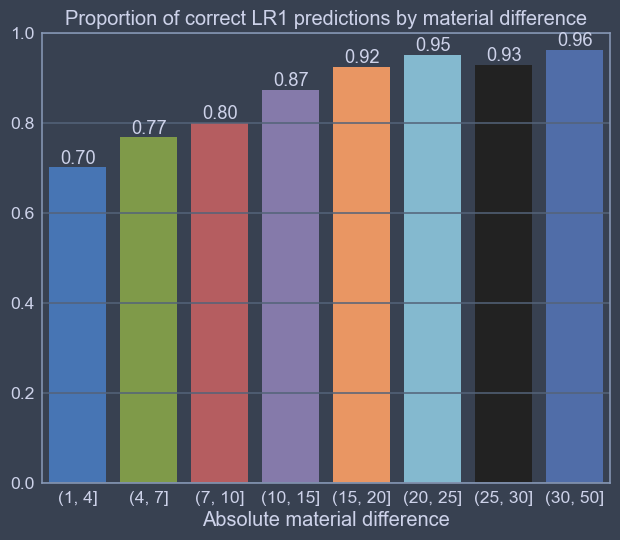

In [152]:
tempdf = X_test[['material_difference_abs_buckets','correct_lr1']].groupby(by='material_difference_abs_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr1'])
plt.ylim(0,1)
plt.title('Proportion of correct LR1 predictions by material difference')
plt.ylabel('')
plt.xlabel('Absolute material difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr1accuracybymaterialdifference.png')

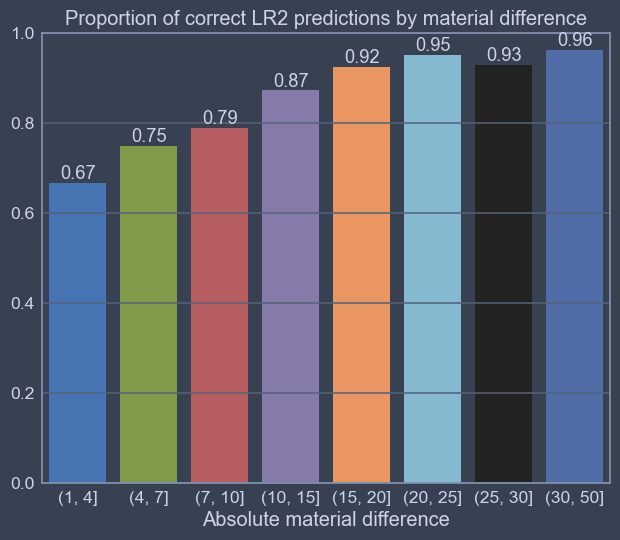

In [153]:
tempdf = X_test[['material_difference_abs_buckets','correct_lr2']].groupby(by='material_difference_abs_buckets').mean()
ax = sns.barplot(x=tempdf.index,y=tempdf['correct_lr2'])
plt.ylim(0,1)
plt.title('Proportion of correct LR2 predictions by material difference')
plt.ylabel('')
plt.xlabel('Absolute material difference')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')
plt.tight_layout()
plt.savefig('./figs/lr2accuracybymaterialdifference.png')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

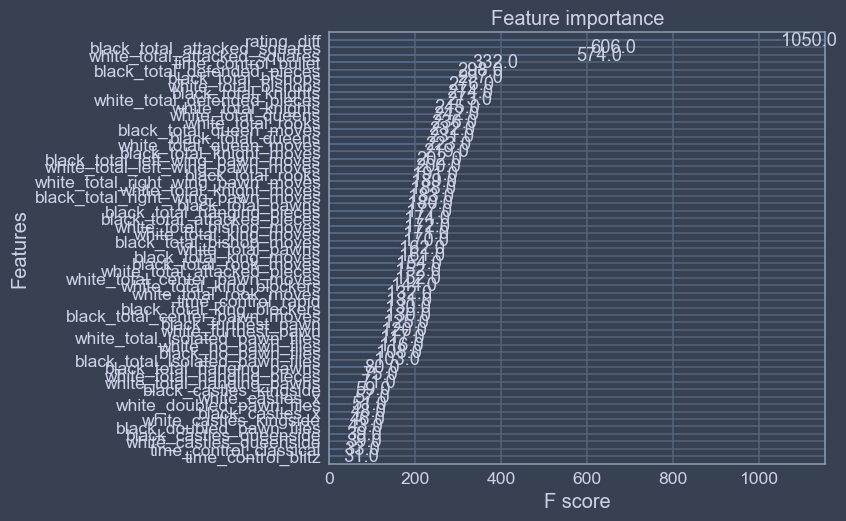

In [158]:
xgb.plot_importance(xgb_model1)